In [1]:
#Self-hyperparam selection: https://link.springer.com/article/10.1007/s11063-024-11578-0
#Self-pruning: https://github.com/skarifahmed/seMLP/blob/main/src/Prune.py

In [2]:
from utils import Utils
from color import color 
import pandas as pd
import numpy as np
import os
# libraries
import joblib

# scale features
from sklearn import preprocessing
from sklearn import impute
# classifier
from sklearn.ensemble import ExtraTreesClassifier
# scoring metrics
from sklearn.metrics import confusion_matrix, matthews_corrcoef

# custom scripts
import sys
sys.path.insert(0, "%s" % "CV/")
from sklearn.model_selection import train_test_split, GridSearchCV, GroupShuffleSplit, StratifiedShuffleSplit, cross_validate, StratifiedKFold
from sklearn.metrics import roc_curve, auc, recall_score, accuracy_score, precision_score, confusion_matrix, make_scorer, matthews_corrcoef, jaccard_score

Hello World !


In [3]:
site_path = "/Users/sanjanayasna/csc334/MLP_MAHOMES/data/sites_calculated_features.txt"

In [4]:
#read in feature set:
sites = pd.read_csv(site_path)
sites = sites.set_index('SITE_ID',drop=True)

# The following labels need to be changed after looking over literature (see Feehan, Franklin, Slusky 2021)
change_site_labels = ["5zb8_0", "6aci_0", "6oq7_0", "6pjv_1", "6q55_0",
                      "6q55_2", "6rmg_0", "6rtg_0", "6rw0_0", "6v77_0"]

# The following sites are removed due to unkopwn correct labels (see Feehan, Franklin, Slusky 2021)
sites.loc[sites.index.isin(change_site_labels), 'Catalytic']=True
remove_sites = ["6mf0_1", "6okh_0", "6qwo_0", "6r9n_0"]
sites=sites.loc[~sites.index.isin(remove_sites)]

#print shape of dataset
print(color.BOLD + "All features:" + color.END)
print("sites: %s \tcolumns: %s"%(sites.shape[0], sites.shape[1]))
sizes = sites.groupby(["Set", "Catalytic"]).size()
print(sizes)

All features:
sites: 3981 	columns: 485
Set   Catalytic
data  False        2636
      True          829
test  False         345
      True          171
dtype: int64


In [5]:
#save_models toggel
save_models = False
#pkl output path
pkl_out = r'/Users/sanjanayasna/csc334/MLP_MAHOMES/pkl'

In [6]:
sites.head()

,Catalytic,MetalCodes,MetalAtoms,fa_atr_Sum_3.5,fa_rep_Sum_3.5,fa_sol_Sum_3.5,fa_intra_atr_xover4_Sum_3.5,fa_intra_rep_xover4_Sum_3.5,fa_intra_sol_xover4_Sum_3.5,lk_ball_Sum_3.5,...,geom_cn8,geom_cn9,geom_Filled,geom_PartFilled,geom_AvgN,geom_AvgO,geom_AvgS,geom_AvgOther,SC_vol_perc,Set
SITE_ID,,,,,,,,,,,,,,,,,,,,,
6s9z_0,True,1,1,-33.20757,20.22373,26.34441,-1.88617,0.46054,2.14096,14.05052,...,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.910384,test
6g5l_0,True,1,1,-27.04899,39.17134,22.76555,-1.71942,0.45999,2.05517,12.94894,...,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.862189,test
6hwz_0,True,1,1,-27.30433,35.04867,23.45195,-1.62146,0.35902,1.91231,13.06378,...,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.991431,test
6qww_0,True,1,1,-25.36664,12.54178,27.17902,-1.14349,0.22087,1.68091,11.47631,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.864546,test
6qww_1,False,1,1,-30.53159,8.99318,27.77842,-1.00782,0.39657,1.04229,13.23736,...,0.0,0.0,1.0,0.0,0.0,4.0,0.0,1.0,0.990893,test


In [7]:
#Get scaled features
data_scaled, Tsites_scaled = Utils.get_scaled_features(sites =sites, pkl_out=pkl_out, save_models=save_models)
#Print stats
print(color.BOLD + "All scaled data-set features:" + color.END)
print("sites: %s \tcolumns: %s"%(data_scaled.shape[0], data_scaled.shape[1]))
print(data_scaled.groupby(["Catalytic"]).size())

print(color.BOLD + "\nAll scaled T-metal-site features:" + color.END)
print("sites: %s \tcolumns: %s"%(Tsites_scaled.shape[0], Tsites_scaled.shape[1]))
print(Tsites_scaled.groupby(["Catalytic"]).size())

All scaled data-set features:
sites: 3465 	columns: 484
Catalytic
False    2636
True      829
dtype: int64

All scaled T-metal-site features:
sites: 516 	columns: 484
Catalytic
False    345
True     171
dtype: int64


In [8]:
dir = "/Users/sanjanayasna/csc334/MLP_MAHOMES/data/"
#save the scaled data
data_scaled.to_csv(os.path.join(dir, "data_scaled.csv"))
Tsites_scaled.to_csv(os.path.join(dir, "Tsites_scaled.csv"))

In [9]:
#set feature set type
MAHOMES_feature_set = "AllMeanSph"

In [10]:
#Well sampled training data
#X is train
#y is target for train
X, y = Utils.get_training_data(MAHOMES_feature_set, random_seed = 1, data_scaled= data_scaled)
 ## prepare test-set
testX = Tsites_scaled.copy()
testY = testX['Catalytic']; del testX['Catalytic']
testX = Utils.feature_subset(testX, MAHOMES_feature_set, noBSA=True)

## get multiple predictions for test-set w/ diff random seeds
test_site_preds = {'actual': pd.Series(testY, index=testX.index)}

#Overview:
# X: training data
# y: target for training data
# testX: test data
# testY: target for test data

In [23]:
import torch.utils.data.sampler as sampler
#Will use subsetRandomSampler (which assumes a shuffle=trfue data loading argument)

In [11]:
#Train input feed params
init_features = len(X.columns)
twice = init_features * 2
print(init_features)

181


In [19]:
from sklearn.metrics import mean_squared_error, r2_score
import torch
def mse_r2_calculator(mlp, test_data, test_targets):
    with torch.no_grad():
        outputs = mlp(test_data)
        predicted_labels = outputs.squeeze().tolist()

    predicted_labels = np.array(predicted_labels)
    test_targets = np.array(test_targets)

    mse = mean_squared_error(test_targets, predicted_labels)
    r2 = r2_score(test_targets, predicted_labels)
    print("Mean Squared Error:", mse)
    print("R2 Score:", r2)

In [13]:
#Loads to torch tensors
class dataLoader:
    #Use ONLY train data 
    def __init__(self, X, y):
        #converts x and y to numpy arr so they can be torch tensor
        if not torch.is_tensor(X) and not torch.is_tensor(y):
            X = X.to_numpy()
            y = y.to_numpy()
        #x_train
        # if not torch.is_tensor(X):
        #     self.X = torch.from_numpy(X)
        # #y_train
        # if not torch.is_tensor(y):
        #     self.y = torch.from_numpy(y)
            
        #To convert boolean to int, do .long()
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y).long()
    def get_trainloader(dataset):
        return torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True, num_workers=1)
    def get_testloader(dataset):
        return torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True, num_workers=1)
    #to get lenght, for enumerator use
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

Starting Epoch 1
Loss after mini-batch     1: 0.001
Loss after mini-batch    11: 0.007
Loss after mini-batch    21: 0.007
Loss after mini-batch    31: 0.006
Loss after mini-batch    41: 0.006
Loss after mini-batch    51: 0.006
Loss after mini-batch    61: 0.005
Loss after mini-batch    71: 0.006
Loss after mini-batch    81: 0.006
Loss after mini-batch    91: 0.005
Loss after mini-batch   101: 0.005
Loss after mini-batch   111: 0.006
Loss after mini-batch   121: 0.006
Loss after mini-batch   131: 0.006
Loss after mini-batch   141: 0.005
Loss after mini-batch   151: 0.005
Loss after mini-batch   161: 0.006
Loss after mini-batch   171: 0.006
Loss after mini-batch   181: 0.005
Loss after mini-batch   191: 0.005
Loss after mini-batch   201: 0.005
Loss after mini-batch   211: 0.005
Loss after mini-batch   221: 0.005
Loss after mini-batch   231: 0.007
Loss after mini-batch   241: 0.006
Loss after mini-batch   251: 0.006
Loss after mini-batch   261: 0.006
Loss after mini-batch   271: 0.005
Los

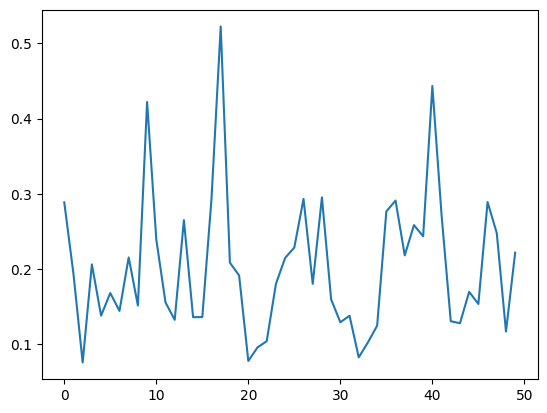

Mean Squared Error: 0.09421305668796993
R2 Score: 0.5747979797344294


In [20]:
#Another attempt https://github.com/daenuprobst/theia/blob/main/src/theia/ml/mlp_classifier.py 
from matplotlib import pyplot as plt


class theiaMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(theiaMLP, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.fc1 = nn.Linear(self.input_size, self.hidden_size)
        self.tanh = nn.Tanh()
        self.fc2 = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, x):
        hidden = self.fc1(x)
        tanh = self.tanh(hidden)
        output = self.fc2(tanh)
        return output
    

#initialize dataloader with random sampling of size 10 
dataset = dataLoader(X, y)
trainloader = torch.utils.data.DataLoader(dataset, batch_size=10, num_workers=0, shuffle = True)
testloader = torch.utils.data.DataLoader(dataset, batch_size=10, num_workers=0, shuffle=True)

#mlp init
mlp = theiaMLP(init_features, 1000, 1)
#set loss function and gradient descet optimizer
loss_function = nn.L1Loss()
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=1e-4)

#train loss
train_loss = []
mlp.train()

#train for this many epochs
for epoch in range(0,50):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))
        optimizer.zero_grad()

        outputs = mlp(inputs)

        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()
        if i%10 == 0:
            print(f'Loss after mini-batch %5d: %.3f'%(i+1, current_loss/500))
            current_loss = 0.0
    train_loss.append(loss.item())
    print(f'Epoch {epoch+1} done')


plt.plot(train_loss)
plt.show()

test_data = torch.from_numpy(testX.to_numpy()).float()
test_targets = torch.from_numpy(testY.to_numpy()).float()

#print mse and r2
mse_r2_calculator(mlp, test_data, test_targets)
#Results
# Mean Squared Error: 0.11795077403554882
# R2 Score: 0.46766500127569677

Starting Epoch 1
Loss after mini-batch     1: 0.000
Loss after mini-batch    11: 0.007
Loss after mini-batch    21: 0.007
Loss after mini-batch    31: 0.005
Loss after mini-batch    41: 0.005
Loss after mini-batch    51: 0.006
Loss after mini-batch    61: 0.006
Loss after mini-batch    71: 0.005
Loss after mini-batch    81: 0.005
Loss after mini-batch    91: 0.006
Loss after mini-batch   101: 0.006
Loss after mini-batch   111: 0.006
Loss after mini-batch   121: 0.006
Loss after mini-batch   131: 0.004
Loss after mini-batch   141: 0.005
Loss after mini-batch   151: 0.005
Loss after mini-batch   161: 0.005
Loss after mini-batch   171: 0.005
Loss after mini-batch   181: 0.005
Loss after mini-batch   191: 0.004
Loss after mini-batch   201: 0.005
Loss after mini-batch   211: 0.006
Loss after mini-batch   221: 0.005
Loss after mini-batch   231: 0.005
Loss after mini-batch   241: 0.006
Loss after mini-batch   251: 0.005
Loss after mini-batch   261: 0.006
Loss after mini-batch   271: 0.005
Los

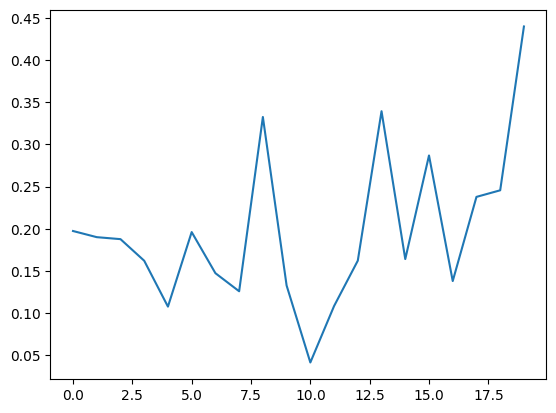

Mean Squared Error: 0.09783460591148274
R2 Score: 0.5584532171244132


In [16]:
#Prelim mlp
#Possible avenue for bias and weight matrix initialization:
## Initialize weights using Xavier uniform initialization
# init.xavier_uniform_(linear_layer.weight)
 
# ## Initialize bias to zero
# init.zeros_(linear_layer.bias)
#---------------------------------
import torch
from torch import nn
from torch.utils.data import DataLoader
#Previous experiment
class MLP(nn.Module):  # nn.Module is the base class for all models in PyTorch
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(init_features, 181),
            nn.ReLU(),
            nn.Linear(181, 90),
            nn.ReLU(),
            nn.Linear(90, 1),
            nn.Sigmoid()
            #try to make output binary (0 or 1)
        )
    def forward(self, x):
     #   x =  self.layers(x)
        return self.layers(x)
    

#initialize dataloader with random sampling of size 10 
dataset = dataLoader(X, y)
trainloader = torch.utils.data.DataLoader(dataset, batch_size=10, num_workers=0, shuffle = True)
testloader = torch.utils.data.DataLoader(dataset, batch_size=10, num_workers=0, shuffle=True)

#mlp init
mlp = theiaMLP(init_features, 1000, 1)
#set loss function and gradient descet optimizer
loss_function = nn.L1Loss()
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=1e-4)

#train loss
train_loss = []
mlp.train()

#train for this many epochs
for epoch in range(0,20):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))
        optimizer.zero_grad()

        outputs = mlp(inputs)

        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()
     

        current_loss += loss.item()
        if i%10 == 0:
            print(f'Loss after mini-batch %5d: %.3f'%(i+1, current_loss/500))
            current_loss = 0.0
    train_loss.append(loss.item())
    
    print(f'Epoch {epoch+1} done')


plt.plot(train_loss)
plt.show()

test_data = torch.from_numpy(testX.to_numpy()).float()
test_targets = torch.from_numpy(testY.to_numpy()).float()

mse_r2_calculator(mlp, test_data, test_targets)
#results
# Mean Squared Error: 0.09783460591148274
# R2 Score: 0.5584532171244132

Loss after mini-batch     1: 0.001
Loss after mini-batch    11: 0.004
Loss after mini-batch    21: 0.004
Loss after mini-batch    31: 0.005
Loss after mini-batch    41: 0.003
Loss after mini-batch    51: 0.004
Loss after mini-batch    61: 0.005
Loss after mini-batch    71: 0.004
Loss after mini-batch    81: 0.004
Loss after mini-batch    91: 0.005
Loss after mini-batch   101: 0.004
Loss after mini-batch   111: 0.004
Loss after mini-batch   121: 0.004
Loss after mini-batch   131: 0.005
Loss after mini-batch   141: 0.004
Loss after mini-batch   151: 0.004
Loss after mini-batch   161: 0.004
Loss after mini-batch   171: 0.004
Loss after mini-batch   181: 0.004
Loss after mini-batch   191: 0.005
Loss after mini-batch   201: 0.004
Loss after mini-batch   211: 0.004
Loss after mini-batch   221: 0.004
Loss after mini-batch   231: 0.004
Loss after mini-batch   241: 0.004
Loss after mini-batch   251: 0.004
Loss after mini-batch   261: 0.004
Loss after mini-batch   271: 0.004
Loss after mini-batc

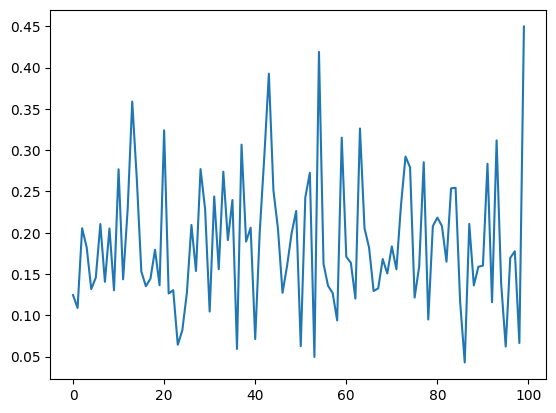

Mean Squared Error: 0.09421305668796993
R2 Score: 0.5747979797344294


In [21]:
from matplotlib import pyplot as plt


batch_size = 10
#This one uses dropout before the output layer

#Layer size
n_hidden1 = 800  # Number of hidden nodes
n_hidden2 = 100
n_output =  1   # Number of output nodes = for binary classifier

class ChurnModel(nn.Module):
    def __init__(self):
        super(ChurnModel, self).__init__()
        self.layer_1 = nn.Linear(init_features, n_hidden1) 
        self.layer_2 = nn.Linear(n_hidden1, n_hidden2)
        self.layer_out = nn.Linear(n_hidden2, n_output) 
        
        self.relu = nn.ReLU()
        self.sigmoid =  nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(n_hidden1)
        self.batchnorm2 = nn.BatchNorm1d(n_hidden2)
        
    
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.sigmoid(self.layer_out(x))
        
        return x
    

model = ChurnModel()

#Loss Computation
loss_func = nn.BCELoss()
#Optimizer
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#After plotting loss functions, lowest value at 17 epochs, but then it goes crazy the rest of the way. More epochs needed
epochs = 100

model.train()
train_loss = []
for epoch in range(epochs):
    #Within each epoch run the subsets of data = batch sizes.
    for i, data in enumerate(trainloader, 0):
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))
        optimizer.zero_grad()

        outputs = mlp(inputs)

        loss = loss_function(outputs, targets)
        #This time optimizer initialized to zero with each epoch
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        current_loss += loss.item()
        if i%10 == 0:
            print(f'Loss after mini-batch %5d: %.3f'%(i+1, current_loss/500))
            current_loss = 0.0
    train_loss.append(loss.item())
print('Last iteration loss value: '+ str(loss.item()))

plt.plot(train_loss)
plt.show()

test_data = torch.from_numpy(testX.to_numpy()).float()
test_targets = torch.from_numpy(testY.to_numpy()).float()

mse_r2_calculator(mlp, test_data, test_targets)


In [22]:
#to resolve missing distutils if your python is most recent:
import setuptools.dist 
#other crap
import tensorflow as tf
from kerastuner.tuners import RandomSearch
import keras_tuner
import keras
from keras import layers

2024-05-10 12:56:53.470803: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/var/folders/dc/rx31slbx2fx8zv76zpst7ry80000gq/T/ipykernel_2815/3151587895.py:5: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [33]:
os.environ["KERAS_BACKEND"] = "torch"

In [34]:
#Now try for Keras hyperparameter optimizer, using the MLP model outlined above:


 # function builder, like original MLP, uses 2 relus, and 2 hidden layers, with signoid at end
def init_model():
    inputs = keras.Input(shape=(init_features,), name = "inputs")
    #first relu
    actv1 = keras.layers.Dense(init_features, activation="relu")(inputs)
    layer1 = keras.layers.Dense(init_features, activation="relu")(actv1)
    #second relu
    actv2 = keras.layers.Dense(init_features, activation="relu")(layer1)
    layer2 = keras.layers.Dense(90, activation="relu")(actv2)
    #sigmoid activation
    actv3 = keras.layers.Dense(90, activation="relu")(layer2)
    output = keras.layers.Dense(1, activation="sigmoid", name = "outputs")(actv3) #shoudl be one binary output, hopefully
    model = keras.Model(inputs=inputs, outputs=output)
    return model
    
#10 is default batch size for everything here
batch_size = 10
#initialize model
model = init_model()
#default adam optimizer
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Instantiate a torch loss function that is default l1loss
loss_fn = torch.nn.L1Loss()
#dataloaders
dataset = dataLoader(X, y)
trainloader = torch.utils.data.DataLoader(dataset, batch_size=10, num_workers=0, shuffle = True)
testloader = torch.utils.data.DataLoader(dataset, batch_size=10, num_workers=0, shuffle=True)
epochs = 20

#train the model
for epoch in range(0,20):
    print(f'Starting Epoch {epoch+1}')
    current_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))
        optimizer.zero_grad()

        #forward pass
        logits = model(inputs)
        #compute loss 
        loss = loss_fn(logits, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()
        if i%10 == 0:
            print(f'Loss after mini-batch %5d: %.3f'%(i+1, current_loss/500))
            current_loss = 0.0
    train_loss.append(loss.item())
    
    print(f'Epoch {epoch+1} done')

# #initialize dataloader with random sampling of size 10 
# dataset = dataLoader(X, y)
# trainloader = torch.utils.data.DataLoader(dataset, batch_size=10, num_workers=0, shuffle = True)
# testloader = torch.utils.data.DataLoader(dataset, batch_size=10, num_workers=0, shuffle=True)

# #mlp init
# mlp = theiaMLP(init_features, 1000, 1)
# #set loss function and gradient descet optimizer
# loss_function = nn.L1Loss()
# optimizer = torch.optim.Adagrad(mlp.parameters(), lr=1e-4)

# #train loss
# train_loss = []
# mlp.train()

# #train for this many epochs
# for epoch in range(0,20):
#     print(f'Starting Epoch {epoch+1}')

#     current_loss = 0.0
#     for i, data in enumerate(trainloader, 0):
#         inputs, targets = data
#         inputs, targets = inputs.float(), targets.float()
#         targets = targets.reshape((targets.shape[0], 1))
#         optimizer.zero_grad()

#         outputs = mlp(inputs)

#         loss = loss_function(outputs, targets)

#         loss.backward()

#         optimizer.step()
     

#         current_loss += loss.item()
#         if i%10 == 0:
#             print(f'Loss after mini-batch %5d: %.3f'%(i+1, current_loss/500))
#             current_loss = 0.0
#     train_loss.append(loss.item())
    
#     print(f'Epoch {epoch+1} done')


# plt.plot(train_loss)
# plt.show()

# test_data = torch.from_numpy(testX.to_numpy()).float()
# test_targets = torch.from_numpy(testY.to_numpy()).float()

# mse_r2_calculator(mlp, test_data, test_targets)

AttributeError: 'Functional' object has no attribute 'parameters'

Starting Epoch 1
Loss after mini-batch     1: 0.001
Loss after mini-batch    11: 0.007
Loss after mini-batch    21: 0.007
Loss after mini-batch    31: 0.008
Loss after mini-batch    41: 0.006
Loss after mini-batch    51: 0.007
Loss after mini-batch    61: 0.006
Loss after mini-batch    71: 0.007
Loss after mini-batch    81: 0.007
Loss after mini-batch    91: 0.005
Loss after mini-batch   101: 0.006
Loss after mini-batch   111: 0.005
Loss after mini-batch   121: 0.007
Loss after mini-batch   131: 0.006
Loss after mini-batch   141: 0.005
Loss after mini-batch   151: 0.006
Loss after mini-batch   161: 0.006
Loss after mini-batch   171: 0.006
Loss after mini-batch   181: 0.005
Loss after mini-batch   191: 0.005
Loss after mini-batch   201: 0.006
Loss after mini-batch   211: 0.006
Loss after mini-batch   221: 0.005
Loss after mini-batch   231: 0.006
Loss after mini-batch   241: 0.005
Loss after mini-batch   251: 0.006
Loss after mini-batch   261: 0.006
Loss after mini-batch   271: 0.005
Los

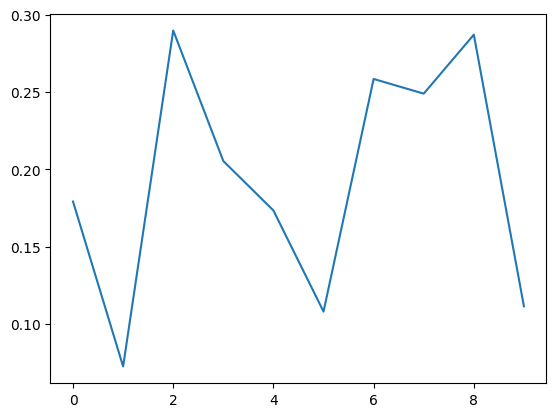

In [ ]:
#USING SKLEARN (original) to lsee loss
from sklearn.neural_network import MLPClassifier
MAHOMES_clf = MLPClassifier(learning_rate_init = 0.01, activation='relu', hidden_layer_sizes= (100,), alpha = 0.001 )

#initialize dataloader with random sampling of size 10 
dataset = dataLoader(X, y)
trainloader = torch.utils.data.DataLoader(dataset, batch_size=10, num_workers=0, shuffle = True)
testloader = torch.utils.data.DataLoader(dataset, batch_size=10, num_workers=0, shuffle=True)

#mlp init
mlp = theiaMLP(init_features, 256, 1)
#set loss function and gradient descet optimizer
loss_function = nn.L1Loss()
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=1e-4)

train_loss = []
#train for this many epochs
for epoch in range(0,10):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))
        optimizer.zero_grad()

        outputs = mlp(inputs)

        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()
        if i%10 == 0:
            print(f'Loss after mini-batch %5d: %.3f'%(i+1, current_loss/500))
            current_loss = 0.0
    train_loss.append(loss.item())
    print(f'Epoch {epoch+1} done')


test_data = torch.from_numpy(testX.to_numpy()).float()
test_targets = torch.from_numpy(testY.to_numpy()).float()
print("Test data correct outputs look like this", test_targets)

from sklearn.metrics import mean_squared_error, r2_score
with torch.no_grad():
    outputs = mlp(test_data)
    predicted_labels = outputs.squeeze().tolist()

predicted_labels = np.array(predicted_labels)
test_targets = np.array(test_targets)

mse = mean_squared_error(test_targets, predicted_labels)
r2 = r2_score(test_targets, predicted_labels)
print("Mean Squared Error:", mse)
print("R2 Score:", r2)

plt.plot(train_loss)
plt.show()
#Results
# Mean Squared Error: 0.10884078202201086
# R2 Score: 0.508780183660541

In [ ]:
#to set num samples variable for dataset
num_samples = len(X)

In [ ]:
#initialize dataloader with random sampling of size 10 
dataset = dataLoader(X, y)
trainloader = torch.utils.data.DataLoader(dataset, batch_size=10, num_workers=0, shuffle = True)
testloader = torch.utils.data.DataLoader(dataset, batch_size=10, num_workers=0, shuffle=True)

In [ ]:
#check that enumerate works
enumerate(trainloader, 0)

In [ ]:
def check_result_metrics(alg, feat_set, prediction_df):
    mcc = matthews_corrcoef(prediction_df['actual'], prediction_df['bool_pred'])
    TN, FP, FN, TP = confusion_matrix(prediction_df['actual'], prediction_df['bool_pred']).ravel()

    TPR=(TP/(TP+FN))*100
    TNR=(TN/(TN+FP))*100
    acc=((TP+TN)/(TP+TN+FP+FN))*100
    Prec=(TP/(TP+FP))*100
    return(pd.DataFrame([[alg, feat_set, acc, mcc, TPR, TNR, Prec]],
        columns=['Algorithm', 'Feature Set', 'Accuracy', 'MCC', 'Recall', 'TrueNegRate', 'Precision']))

In [ ]:
#train for this many epochs
for epoch in range(0,10):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))
        optimizer.zero_grad()

        outputs = mlp(inputs)

        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()
        if i%10 == 0:
            print(f'Loss after mini-batch %5d: %.3f'%(i+1, current_loss/500))
            current_loss = 0.0
    
    print(f'Epoch {epoch+1} done')

In [ ]:
test_data = torch.from_numpy(testX.to_numpy()).float()
test_targets = torch.from_numpy(testY.to_numpy()).float()
print("Test data correct outputs look like this", test_targets)

Test data correct outputs look like this tensor([1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.,
        1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
        1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
        1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,

In [ ]:
#Run mlp model on test data
mlp.eval() 

MLP(
  (layers): Sequential(
    (0): Linear(in_features=181, out_features=181, bias=True)
    (1): ReLU()
    (2): Linear(in_features=181, out_features=90, bias=True)
    (3): ReLU()
    (4): Linear(in_features=90, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [ ]:
predicted_labels

array([ 0.55222297,  0.60099828,  0.33700261,  0.16569516,  0.12786084,
       -0.09439341,  0.61105984,  0.29831496,  0.37959674,  0.37540489,
        0.53442001,  0.51242977,  0.37768754,  0.4436639 ,  0.3295171 ,
        0.00305723, -0.11090554, -0.03113469,  0.55659735,  0.51181453,
        0.52106255,  0.63306159,  0.35841542,  0.48058605,  0.35919982,
        0.57094032,  0.26341119,  0.48409846,  0.51234937,  0.50355482,
        0.4831036 ,  0.76673108,  0.54336435,  0.14401197,  0.07484119,
        0.07294383,  0.05787735,  0.14886454, -0.05228285,  0.01234505,
        0.48948708,  0.2463991 ,  0.58187437,  0.76498759,  0.40710023,
        0.8641566 ,  0.9011901 ,  0.20198449,  0.08673712,  0.44957846,
        0.02019858,  0.47610286,  0.45234445,  0.51072431, -0.03460576,
        0.57820815,  0.77991104,  0.7748298 ,  0.64841223,  0.65430748,
        1.04801929,  0.54572093,  0.49992767,  0.51271564,  0.46790716,
        0.69760609,  0.78038943,  0.14870211,  0.3384459 ,  0.12

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
with torch.no_grad():
    outputs = mlp(test_data)
    predicted_labels = outputs.squeeze().tolist()

predicted_labels = np.array(predicted_labels)
test_targets = np.array(test_targets)

mse = mean_squared_error(test_targets, predicted_labels)
r2 = r2_score(test_targets, predicted_labels)
print("Mean Squared Error:", mse)
print("R2 Score:", r2)
# Mean Squared Error: 0.18271737790066617
# R2 Score: 0.17536060337896386
# So absolute crap, but it's a start

Mean Squared Error: 0.1768569084712416
R2 Score: 0.20181005241179772
